In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import io
import regex
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as plt
from scipy import sparse

# Upload Data

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/CayJoBla/EmotionRecognition/master/data/original_data.csv', index_col=0)

In [3]:
tweet_data = df.copy()
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 1956967341 to 1753919049
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  40000 non-null  object
 1   content    40000 non-null  object
dtypes: object(2)
memory usage: 937.5+ KB


## Consolidate and encode classes

In [4]:
# Original classes
np.sort(pd.unique(tweet_data['sentiment']))

array(['anger', 'boredom', 'empty', 'enthusiasm', 'fun', 'happiness',
       'hate', 'love', 'neutral', 'relief', 'sadness', 'surprise',
       'worry'], dtype=object)

In [5]:
# New classes
tweet_data.loc[tweet_data["sentiment"]=="empty", "sentiment"] = "sadness"
tweet_data.loc[tweet_data["sentiment"]=="boredom", "sentiment"] = "neutral"
tweet_data.loc[tweet_data["sentiment"]=="hate", "sentiment"] = "anger"
tweet_data.loc[tweet_data["sentiment"]=="fun", "sentiment"] = "enthusiasm"
np.sort(pd.unique(tweet_data['sentiment']))

array(['anger', 'enthusiasm', 'happiness', 'love', 'neutral', 'relief',
       'sadness', 'surprise', 'worry'], dtype=object)

In [6]:
# Encode
tweet_data["sentiment"] = tweet_data["sentiment"].astype('category').cat.codes

## Clean and organize tweet text

In [7]:
# Define identifiers
urls = r"http:[^\s]+|w{3}\.[^\s]+|[\w]+\.[\w]{3}[/\w]*"
users = r"@(\w){1,}"
tags = r"#(\w){1,}"
errors = r"&[\w]+;"
symbols = r"[_~$/%/^/&/*-/+/=/\/|///?/!:;\"<>,]|[.]+"
words = r"[\w]+"

# Parse unique identifiers
tweet_data['num_urls'] = tweet_data['content'].apply(lambda text: len(regex.findall(urls, text.lower()))).values
tweet_data['content_parsed'] = tweet_data['content'].apply(lambda text: regex.sub(urls, "", text)).values
tweet_data['num_pings'] = tweet_data['content_parsed'].apply(lambda text: len(regex.findall(users, text.lower()))).values
tweet_data['content_parsed'] = tweet_data['content_parsed'].apply(lambda text: regex.sub(users, "", text)).values
tweet_data['num_tags'] = tweet_data['content_parsed'].apply(lambda text: len(regex.findall(tags, text.lower()))).values
tweet_data['content_parsed'] = tweet_data['content_parsed'].apply(lambda text: regex.sub(tags, "", text)).values
tweet_data['#!'] = tweet_data['content_parsed'].str.count('!')
tweet_data['#?'] = tweet_data['content_parsed'].str.count('\\?')
tweet_data['#...'] = tweet_data['content_parsed'].str.count('\\.{2,}')
tweet_data['content_parsed'] = tweet_data['content_parsed'].apply(lambda text: text.replace('ï', ''))
tweet_data['content_parsed'] = tweet_data['content_parsed'].apply(lambda text: text.replace('½', ''))
tweet_data['content_parsed'] = tweet_data['content_parsed'].apply(lambda text: regex.sub(errors, " ", text)).values
tweet_data['content_parsed'] = tweet_data['content_parsed'].apply(lambda text: regex.sub(symbols, " ", text)).values
tweet_data['content_parsed'] = tweet_data['content_parsed'].apply(lambda text: regex.sub(r"'", "", text)).values
tweet_data['Upper/Lower ratio'] = (tweet_data['content_parsed'].str.findall(r'[A-Z]').str.len()+1) / (tweet_data['content_parsed'].str.findall(r'[a-z]').str.len()+1)
tweet_data['words'] = tweet_data['content_parsed'].apply(lambda text: regex.findall(words, text.lower())).values
tweet_data['num_words'] = tweet_data['words'].apply(lambda n: len(n))
tweet_data["avg_word_len"] = tweet_data['words'].apply(lambda word_array: np.mean([len(word) for word in word_array]))

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [8]:
tweet_data.isna().sum()

sentiment              0
content                0
num_urls               0
content_parsed         0
num_pings              0
num_tags               0
#!                     0
#?                     0
#...                   0
Upper/Lower ratio      0
words                  0
num_words              0
avg_word_len         100
dtype: int64

In [9]:
# Avg word len is NaN when there are no words in the tweet, set to 0
tweet_data = tweet_data.fillna(0)
tweet_data.isna().sum()

sentiment            0
content              0
num_urls             0
content_parsed       0
num_pings            0
num_tags             0
#!                   0
#?                   0
#...                 0
Upper/Lower ratio    0
words                0
num_words            0
avg_word_len         0
dtype: int64

### Data Analysis

In [10]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(tweet_data["content_parsed"].values)
total_counts = np.array(np.sum(X, axis=0))[0]

print("Minimum word count:", np.min(total_counts))
print("Maximum word count:", np.max(total_counts))
print("Mean word count:", np.mean(total_counts))

Minimum word count: 1
Maximum word count: 14377
Mean word count: 15.65839630843309


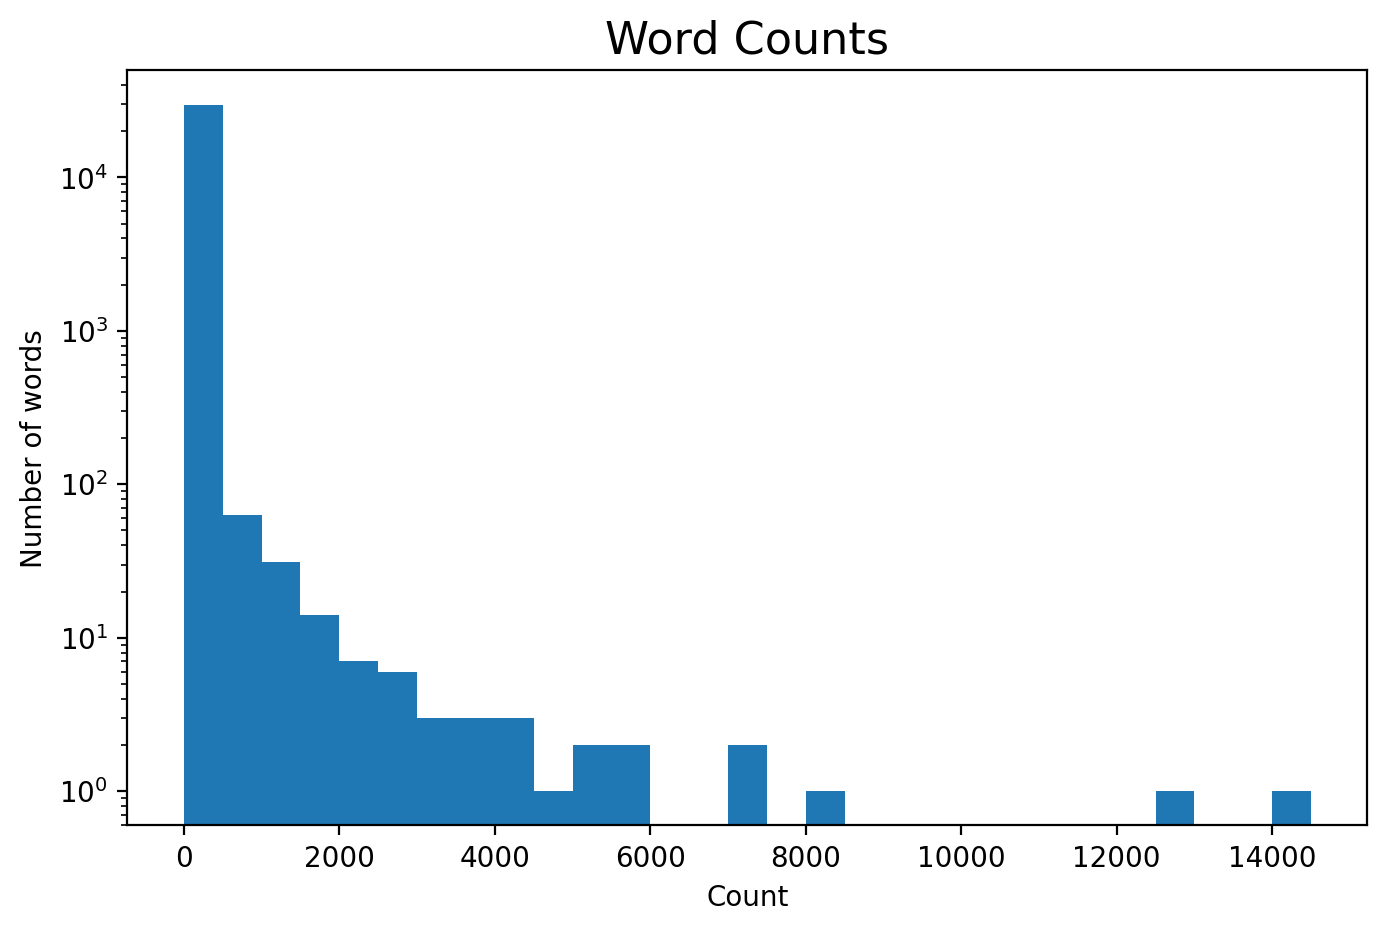

In [11]:
fig, ax = plt.subplots(1, 1, dpi=200, figsize=(8,5))
ax.hist(total_counts, bins=np.arange(0,15000,500))
ax.set_title("Word Counts", size=16)
ax.set_xlabel("Count")
ax.set_ylabel("Number of words")
ax.set_yscale('log')
plt.savefig("original_counts.png")
plt.show()

In [12]:
# Save full dataset as a sparse matrix
X = sparse.csc_matrix(X)
print("Full bag of words dimensions:", X.shape)

# Convert to sparse matrix
full_data = sparse.hstack((tweet_data.drop(columns=["words","content","content_parsed"]).values, X), format='csr')

# Move labels to the opposite side
full_data = sparse.hstack((full_data[:, 1:], full_data[:, :1]), format='csr')

print("Full dataset dimensions:", full_data.shape)
sparse.save_npz("cleaned_data_full.npz", full_data)

Full bag of words dimensions: (40000, 29906)
Full dataset dimensions: (40000, 29916)


### Remove columns with too many or too few counts

In [13]:
names = vectorizer.get_feature_names_out()
print("Commonly used words to drop:", end=" ")
print(*names[total_counts > 7000], sep=', ')
# X = X[:,total_counts <= 7000]         # Drop too many
# X = X[:,total_counts >= 5]            # Drop too few
# names = names[counts >= 5]


Commonly used words to drop: and, my, the, to, you


### Save dataframe for later computation

In [14]:
tweet_data.drop(columns=["words","content","content_parsed"]).to_csv("cleaned_data.csv")